In [1]:
import os
import glob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexisfirome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words('french') + ["ee", "gr", "oe", "eee", "be", "oo", "ii", "ct", "we", "ie", "at", "qf", "pe", "he", "an", "eae", "ey",
                                              "fe", "eo", "er", "ea", "ge", "see", "ay", "ees", "pee", "so", "oa", "of","ar", "ete", "ja", "ye", "pa"
                                              "ve", "aes", "ree", "cest"])

In [36]:
# Répertoire des fichiers
data_dir = {
    "masculin": "../data/txt/txt_merged/masculins",
    "feminin": "../data/txt/txt_merged/feminins",
    "mixte" : "../data/txt/txt_merged/mixtes"
}

def load_data(data_dir):
    texts, labels = [], []
    for label, path in data_dir.items():
        for file_path in glob.glob(os.path.join(path, "*.txt")):
            with open(file_path, 'r', encoding='utf-8') as f:
                texts.append(f.read())
                labels.append(label)
    return texts, labels

texts, labels = load_data(data_dir)

def preprocess_text(text):
    # Nettoyage de base
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

processed_texts = [preprocess_text(text) for text in texts]

# Convertir l'ensemble des stopwords en liste
stop_words_list = list(stop_words)

# Utilisation dans CountVectorizer
vectorizer = CountVectorizer( input = 'content', max_df=0.95, min_df=2, stop_words=stop_words_list)
X = vectorizer.fit_transform(processed_texts)



In [37]:
# Modèle LDA
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X)

# Ajouter une condition pour filtrer les topics
def filter_topics(model, feature_names, threshold=0.5):
    filtered_topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        if max(topic) > threshold:
            filtered_topics.append((topic_idx + 1, topic_words))
    return filtered_topics

filtered_topics = filter_topics(lda, vectorizer.get_feature_names_out(), threshold=0.1)
print("Topics filtrés:")
for topic_idx, topic_words in filtered_topics:
    print(f"Topic {topic_idx}: {', '.join(topic_words)}")

n_top_words = 1
filter_topics(lda, vectorizer.get_feature_names_out(), n_top_words)


Topics filtrés:
Topic 1: ve
Topic 2: gymnastique
Topic 3: fic
Topic 4: nature
Topic 5: eft
Topic 6: malades
Topic 7: enfant
Topic 8: tuberculose
Topic 9: enfants
Topic 10: traitement


[(1, ['ve']),
 (2, ['gymnastique']),
 (3, ['fic']),
 (4, ['nature']),
 (5, ['eft']),
 (6, ['malades']),
 (7, ['enfant']),
 (8, ['tuberculose']),
 (9, ['enfants']),
 (10, ['traitement'])]

In [38]:
# Associez les documents à leurs topics dominants
doc_topic_distribution = lda.transform(X)
df_results = pd.DataFrame(doc_topic_distribution, columns=[f"Topic {i+1}" for i in range(lda.n_components)])
df_results['Genre'] = labels

# Moyenne des proportions de chaque topic par genre
mean_topics_by_genre = df_results.groupby('Genre').mean()
print(mean_topics_by_genre)


           Topic 1   Topic 2   Topic 3   Topic 4   Topic 5   Topic 6  \
Genre                                                                  
feminin   0.056761  0.009072  0.032387  0.081797  0.000013  0.033279   
masculin  0.042361  0.043154  0.000044  0.230174  0.075001  0.000151   
mixte     0.042542  0.271701  0.057129  0.154973  0.000009  0.000009   

           Topic 7   Topic 8   Topic 9  Topic 10  
Genre                                             
feminin   0.537863  0.042052  0.043582  0.163195  
masculin  0.360228  0.010541  0.077467  0.160879  
mixte     0.367178  0.000009  0.000009  0.106443  


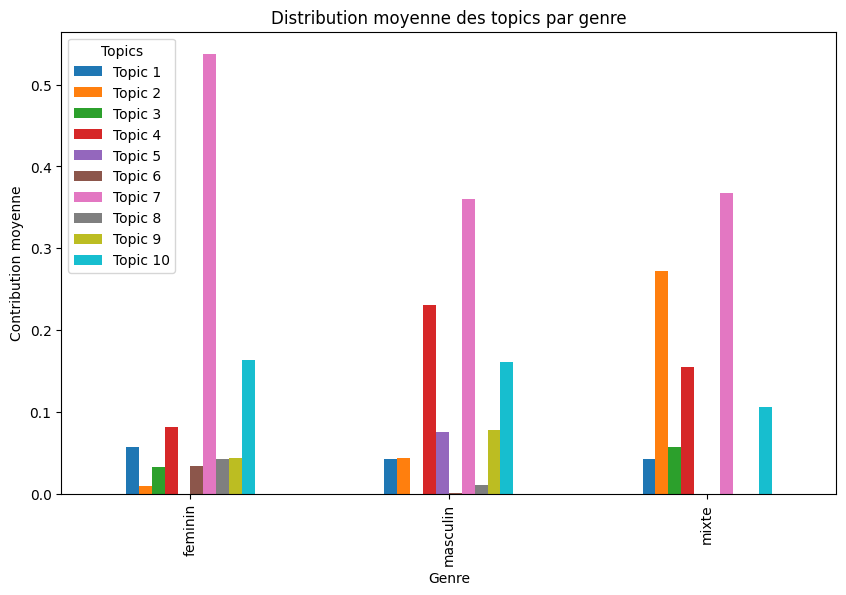

In [39]:
import matplotlib.pyplot as plt

mean_topics_by_genre.plot(kind='bar', figsize=(10, 6))
plt.title("Distribution moyenne des topics par genre")
plt.ylabel("Contribution moyenne")
plt.xlabel("Genre")
plt.legend(title="Topics")
plt.show()


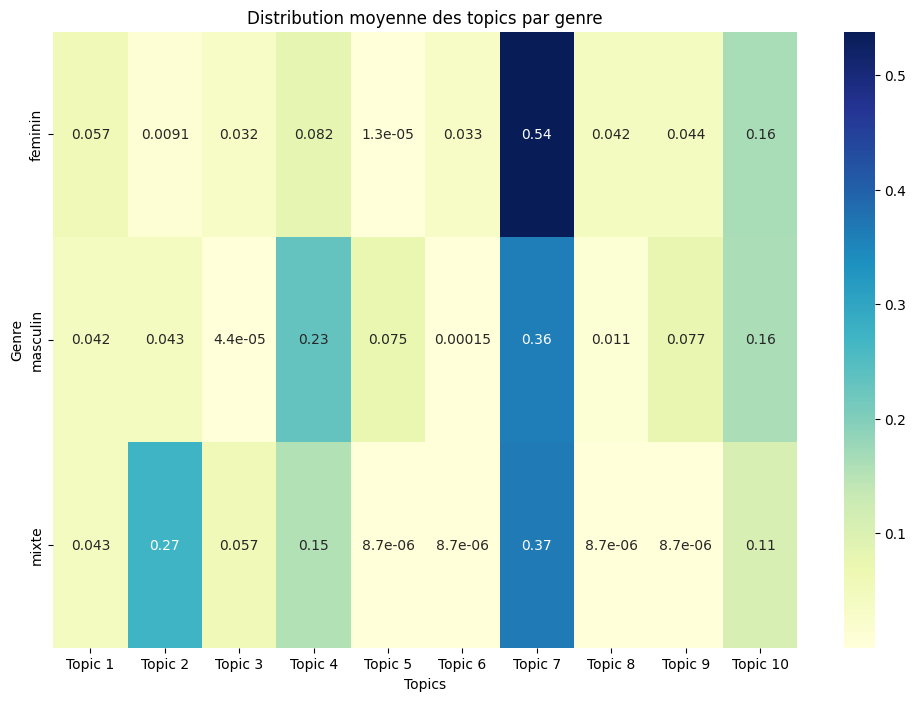

In [40]:
import seaborn as sns

# Heatmap de la distribution moyenne des topics par genre
plt.figure(figsize=(12, 8))
sns.heatmap(mean_topics_by_genre, annot=True, cmap="YlGnBu", cbar=True)
plt.title("Distribution moyenne des topics par genre")
plt.ylabel("Genre")
plt.xlabel("Topics")
plt.show()

## compex


In [60]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


stop_words = set(stopwords.words('french') + [
    "alors", "au", "aucuns", "aussi", "autre", "avant", "avec", "avoir", "bon", "car", "ce", "cela", "ces", "ceux", 
    "chaque", "ci", "comme", "comment", "dans", "des", "du", "dedans", "dehors", "depuis", "devrait", "doit", "donc", 
    "dos", "début", "elle", "elles", "en", "encore", "essai", "est", "et", "eu", "fait", "faites", "fois", "font", 
    "hors", "ici", "il", "ils", "je", "juste", "la", "le", "les", "leur", "là", "ma", "maintenant", "mais", "mes", 
    "mine", "moins", "mon", "mot", "même", "ni", "nommés", "notre", "nous", "nouveaux", "ou", "où", "par", "parce", 
    "pas", "peut", "peu", "plupart", "pour", "pourquoi", "quand", "que", "quel", "quelle", "quelles", "quels", "qui", 
    "sa", "sans", "ses", "seulement", "si", "sien", "son", "sont", "sous", "soyez", "sujet", "sur", "ta", "tandis", 
    "tellement", "tels", "tes", "ton", "tous", "tout", "trop", "très", "tu", "valeur", "voie", "voient", "vont", 
    "votre", "vous", "vu", "ça", "étaient", "état", "étions", "été", "être", "de", "a", "4", "-", "une", "plus","7", 
    "un", "se", "'", "_",'‘', 'ne', "cette", "bien", "toujours", "si", "aussi", "peu", "deux", "trois", "quatre", 
    "cinq", "nature", "faire", "faut", "peut", "doit", "doivent", "peuvent", "chez", "méme", "soit", "dont", "non", 
    "tous", "toutes", "toute", "c’est", "dune", "d’une", "tant", "ainsi", "cest", "surtout", "étre", "pourtant", 
    "souvent", "trés", "leurs", "quelques", " ", "pendant", "aprés", "autres", "ment", "celle", "beaucoup", "ee", "etre","meme",
    "gr", "oe", "eee", "be", "oo", "ii", "ct", "we", "ie", "at", "qf", "pe", "he", "an", "eae", "ey", "fe", "eo", "ae", "re"
    "er", "ea", "ge", "see", "ay", "ees", "pee", "so", "oa", "of","ar", "ete", "ja", "ye", "pa" "ve", "aes", "ree", "cest"])


def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
    
data_dir = {
    "masculin": "../data/txt/txt_merged/masculins",
    "feminin": "../data/txt/txt_merged/feminins",
    "mixte" : "../data/txt/txt_merged/mixtes"
}

def load_data(data_dir):
    texts, labels = [], []
    for label, path in data_dir.items():
        for file_path in glob.glob(os.path.join(path, "*.txt")):
            with open(file_path, 'r', encoding='utf-8') as f:
                texts.append(f.read())
                labels.append(label)
    return texts, labels

texts, labels = load_data(data_dir)

data_words = list(sent_to_words(texts))
# remove stop words
data_words = remove_stopwords(data_words)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexisfirome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


In [62]:
from pprint import pprint
# number of topics
num_topics = 5
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.004*"femme" + 0.003*"tres" + 0.002*"femmes" + 0.002*"dun" + '
  '0.002*"enfants" + 0.002*"enfant" + 0.002*"lait" + 0.002*"apres" + '
  '0.002*"cas" + 0.002*"temps"'),
 (1,
  '0.004*"femme" + 0.003*"lait" + 0.003*"enfants" + 0.003*"enfant" + '
  '0.002*"femmes" + 0.002*"tres" + 0.002*"dun" + 0.002*"nest" + 0.002*"cas" + '
  '0.002*"vie"'),
 (2,
  '0.003*"femme" + 0.003*"tres" + 0.003*"enfant" + 0.003*"enfants" + '
  '0.003*"point" + 0.002*"femmes" + 0.002*"dun" + 0.002*"temps" + 0.002*"cas" '
  '+ 0.002*"nest"'),
 (3,
  '0.003*"femme" + 0.003*"tres" + 0.003*"enfant" + 0.002*"dun" + 0.002*"temps" '
  '+ 0.002*"lait" + 0.002*"femmes" + 0.002*"enfants" + 0.002*"nest" + '
  '0.002*"maladies"'),
 (4,
  '0.005*"femme" + 0.003*"tres" + 0.003*"enfant" + 0.002*"femmes" + '
  '0.002*"enfants" + 0.002*"lait" + 0.002*"quon" + 0.002*"cas" + '
  '0.002*"hygiene" + 0.002*"dun"')]


In [63]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
os.makedirs(os.path.dirname(LDAvis_data_filepath), exist_ok=True)
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.002804  0.001216       1        1  48.121089
4      0.000118 -0.001457       2        1  20.273308
0      0.000443 -0.001201       3        1  13.726479
2     -0.001802  0.001890       4        1  10.842851
3     -0.001563 -0.000448       5        1   7.036273, topic_info=          Term         Freq        Total Category  logprob  loglift
20496     tres  6163.000000  6163.000000  Default  30.0000  30.0000
7815     femme  8576.000000  8576.000000  Default  29.0000  29.0000
6726    enfant  5750.000000  5750.000000  Default  28.0000  28.0000
19988    temps  3718.000000  3718.000000  Default  27.0000  27.0000
6069       dun  4766.000000  4766.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
9165   hygiene   209.068604  3061.841052   Topic5  -6.5806  -0.0300
21392      vie   221.344720  3687.517269   Topic5  -6.5235  -0.1589
16465     quon   226.123014  3878.033873   Topic5  -6.5022  -0.1879
12492     mere   203.646164  3212.578042   Topic5  -6.6069  -0.1044
3649    contre   176.959469  2892.542751   Topic5  -6.7473  -0.1399

[517 rows x 6 columns], token_table=        Topic      Freq        Term
term                               
27102       1  0.378759  adrenaline
27102       2  0.189379  adrenaline
27102       3  0.189379  adrenaline
27102       4  0.189379  adrenaline
22294       1  0.393730  affegtions
...       ...       ...         ...
104591      1  0.595464        zoco
104591      2  0.158791        zoco
104591      3  0.119093        zoco
104591      4  0.079395        zoco
104591      5  0.039698        zoco

[1635 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 1, 3, 4])